In [1]:
import os

base_path = "dataset"

folders = ["2_crawling","3_crying","4_dancing","5_eating","7_falling_slide","8_falling","9_playing_w_animals","10_playing_w_toy","12_smiling","15_walking"]

video_label_dict = {}

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith(".mp4"):
            video_path = os.path.join(folder_path, file)
            video_label_dict[video_path] = folder

print(video_label_dict)

{'dataset/2_crawling/crawling016.mp4': '2_crawling', 'dataset/2_crawling/crawling022.mp4': '2_crawling', 'dataset/2_crawling/crawling017.mp4': '2_crawling', 'dataset/2_crawling/crawling007.mp4': '2_crawling', 'dataset/2_crawling/crawling061.mp4': '2_crawling', 'dataset/2_crawling/crawling070.mp4': '2_crawling', 'dataset/2_crawling/crawling076.mp4': '2_crawling', 'dataset/2_crawling/crawling006.mp4': '2_crawling', 'dataset/2_crawling/crawling060.mp4': '2_crawling', 'dataset/2_crawling/crawling004.mp4': '2_crawling', 'dataset/2_crawling/crawling036.mp4': '2_crawling', 'dataset/2_crawling/crawling074.mp4': '2_crawling', 'dataset/2_crawling/crawling067.mp4': '2_crawling', 'dataset/2_crawling/crawling003.mp4': '2_crawling', 'dataset/2_crawling/crawling035.mp4': '2_crawling', 'dataset/2_crawling/crawling010.mp4': '2_crawling', 'dataset/2_crawling/crawling054.mp4': '2_crawling', 'dataset/2_crawling/crawling001.mp4': '2_crawling', 'dataset/2_crawling/crawling019.mp4': '2_crawling', 'dataset/2_

In [2]:
!pip install timm

In [3]:
video_label_list = list(video_label_dict.items())
video_paths = list(video_label_dict.keys())
video_labels = list(video_label_dict.values())

In [4]:
from sklearn.preprocessing import LabelEncoder
label_mapping = {
    "2_crawling": 0,
    "3_crying": 1,
    "4_dancing": 2,
    "5_eating": 3,
    "7_falling_slide": 4,
    "8_falling": 5,
    "9_playing_w_animals": 6,
    "10_playing_w_toy": 7,
    "12_smiling": 8,
    "15_walking": 9,
}
label_encoder = LabelEncoder()
label_encoder.fit([label_mapping[label] for label in video_labels])
labels_encoder = label_encoder.transform([label_mapping[label] for label in video_labels])

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training (70%) and temporary (30%) sets
train_video_paths, test_video_paths, train_video_labels, test_video_labels = train_test_split(
    video_paths, labels_encoder, test_size=0.3, stratify=video_labels, random_state=42
)

# Split the temporary data into testing (20% of original data) and validation (10% of original data) sets
val_video_paths, test_video_paths, val_video_labels, test_video_labels = train_test_split(
    test_video_paths, test_video_labels, test_size=2/3, stratify=test_video_labels, random_state=42
)


In [6]:
len(train_video_paths)

213

In [7]:
len(test_video_paths)

62

In [8]:
len(val_video_paths)

30

In [9]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn

from PIL import Image
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, num_frames, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        video_frames = self._get_video_frames(video_path)
        label = self.labels[idx]
        
        if self.transform:
            video_frames = torch.stack([self.transform(frame) for frame in video_frames])

        return video_frames, label, video_path
    
#     def _get_video_frames(self, video_path):
#         frames = []
#         video = cv2.VideoCapture(video_path)
#         while len(frames) < self.num_frames:
#             ret, frame = video.read()
#             if not ret:
#                 break
#             image = Image.fromarray(frame)
#             frames.append(image)
#         video.release()
#         return frames
    def _get_video_frames(self, video_path):
        frames = []
        video = cv2.VideoCapture(video_path)
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

        frame_indices = np.linspace(0, total_frames-1, self.num_frames, dtype=int)

        for frame_index in frame_indices:
            video.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = video.read()
            if not ret:
                break
            image = Image.fromarray(frame)
            frames.append(image)
        video.release()
        return frames

In [10]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [11]:
train_dataset = VideoDataset(train_video_paths, train_video_labels, num_frames=16, transform=preprocess)
test_dataset = VideoDataset(test_video_paths, test_video_labels, num_frames=16, transform=preprocess)
val_dataset = VideoDataset(val_video_paths, val_video_labels, num_frames=16, transform=preprocess)

In [12]:
data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

In [13]:
# Define the hyperparameters for the LSTM
lstm_hidden_dim = 256
lstm_num_layers = 2

# Number of output features from the feature extractor
in_features = 768  # change this according to the variant of swin transformer you're using

# Number of classes in your dataset
num_classes = 10

class VideoClassificationModel(nn.Module):
    def __init__(self, feature_extractor, num_classes, lstm_hidden_dim, lstm_num_layers):
        super(VideoClassificationModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.lstm = nn.LSTM(
            input_size=in_features, 
            hidden_size=lstm_hidden_dim, 
            num_layers=lstm_num_layers,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_dim, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.4),  # Dropout layer
            nn.Linear(in_features=64, out_features=num_classes, bias=True)
        )

        
        #self.fc = nn.Linear(lstm_hidden_dim, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        x = x.view(batch_size * timesteps, C, H, W)
        x = self.feature_extractor(x)  # Output shape: (batch_size*timesteps, num_features)
        x = x.view(batch_size, timesteps, -1)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Use the last LSTM output
        return x


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
import timm

HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
swin_transformer_model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

Using cache found in /home/ubuntu/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
from torchvision.models import resnet50

# Replace the last layer with an identity mapping
swin_transformer_model.head = nn.Identity()

# Disable gradient computation for all layers in the Swin Transformer model
for param in swin_transformer_model.parameters():
    param.requires_grad = False

# The modified Swin Transformer model is your feature extractor
feature_extractor = swin_transformer_model


model = VideoClassificationModel(feature_extractor, num_classes=10, lstm_hidden_dim=lstm_hidden_dim, lstm_num_layers=lstm_num_layers)

print(model)

VideoClassificationModel(
  (feature_extractor): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=96, input_resolution=(56, 56), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=96, window_size=(7, 7), num_heads=3
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): S

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [18]:
import numpy as np

In [19]:
import matplotlib.pyplot as plt
# Create lists to store the loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []


# Move model to the device
model = model.to(device)

# Set the number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    for inputs, labels, _ in data_loader_train:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels)

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(data_loader_train.dataset)
    train_acc = correct_predictions.double() / len(data_loader_train.dataset) *100
    
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc/100)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels, _ in data_loader_test:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            correct_predictions += torch.sum(preds == labels)

    test_loss = running_loss / len(data_loader_test.dataset)
    test_acc = correct_predictions.double() / len(data_loader_test.dataset) *100
    
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc/100)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch 1/10: Train Loss: 2.2962, Train Acc: 9.86%, Test Loss: 2.2850, Test Acc: 12.90%
Epoch 2/10: Train Loss: 2.2733, Train Acc: 17.84%, Test Loss: 2.2628, Test Acc: 25.81%
Epoch 3/10: Train Loss: 2.2316, Train Acc: 30.99%, Test Loss: 2.2048, Test Acc: 38.71%
Epoch 4/10: Train Loss: 2.1308, Train Acc: 38.03%, Test Loss: 2.0123, Test Acc: 45.16%
Epoch 5/10: Train Loss: 1.8588, Train Acc: 45.07%, Test Loss: 1.7143, Test Acc: 53.23%
Epoch 6/10: Train Loss: 1.5851, Train Acc: 50.70%, Test Loss: 1.5634, Test Acc: 53.23%
Epoch 7/10: Train Loss: 1.3083, Train Acc: 61.03%, Test Loss: 1.4547, Test Acc: 56.45%
Epoch 8/10: Train Loss: 1.0341, Train Acc: 71.36%, Test Loss: 1.4150, Test Acc: 51.61%
Epoch 9/10: Train Loss: 0.8683, Train Acc: 78.87%, Test Loss: 1.3404, Test Acc: 54.84%
Epoch 10/10: Train Loss: 0.6806, Train Acc: 83.57%, Test Loss: 1.3347, Test Acc: 56.45%


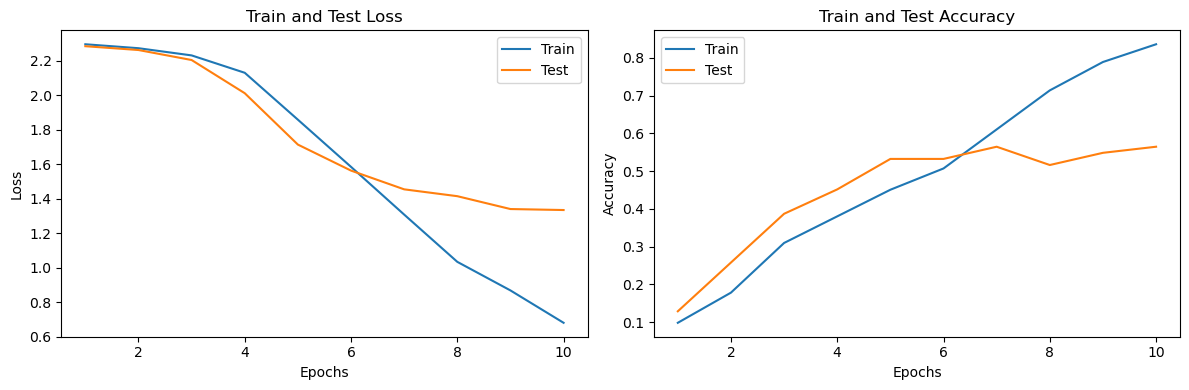

In [20]:
# Plotting the curves
epochs = range(1, num_epochs+1)


# Plotting loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train')
plt.plot(epochs, test_loss_values, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, [x.item() for x in train_acc_values], label='Train')
plt.plot(epochs, [x.item() for x in test_acc_values], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [21]:
model.eval()
running_loss = 0.0
correct_predictions_top1 = 0
correct_predictions_top5 = 0

with torch.no_grad():
    for inputs, labels, _ in data_loader_val:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        correct_predictions_top1 += torch.sum(preds == labels)
        
        # Calculate top-5 accuracy
        _, pred_labels_top5 = torch.topk(outputs, k=5, dim=1)
        correct_predictions_top5 += torch.sum(pred_labels_top5 == labels.view(-1, 1))

epoch_loss = running_loss / len(data_loader_test.dataset)
epoch_acc_top1 = correct_predictions_top1.double() / len(data_loader_val.dataset)
epoch_acc_top5 = correct_predictions_top5.double() / len(data_loader_val.dataset)

print(f"Top-1 Accuracy: {epoch_acc_top1.item() * 100:.2f}%")
print(f"Top-5 Accuracy: {epoch_acc_top5.item() * 100:.2f}%")


Top-1 Accuracy: 50.00%
Top-5 Accuracy: 83.33%


In [22]:
model.eval()
running_loss = 0.0
correct_counts = {}
total_counts = {}

with torch.no_grad():
    for inputs, labels, _ in data_loader_val:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)

        for true_label, pred_label in zip(labels, preds):
            if true_label.item() in total_counts:
                total_counts[true_label.item()] += 1
            else:
                total_counts[true_label.item()] = 1

            if true_label.item() == pred_label.item():
                if true_label.item() in correct_counts:
                    correct_counts[true_label.item()] += 1
                else:
                    correct_counts[true_label.item()] = 1

epoch_loss = running_loss / len(data_loader_val.dataset)

print("Top-1 Accuracy by True Label:")
for label in sorted(total_counts.keys()):
    accuracy = correct_counts.get(label, 0) / total_counts[label]
    print(f"True Label: {label}, Accuracy: {accuracy * 100:.2f}%")


Top-1 Accuracy by True Label:
True Label: 0, Accuracy: 33.33%
True Label: 1, Accuracy: 66.67%
True Label: 2, Accuracy: 0.00%
True Label: 3, Accuracy: 0.00%
True Label: 4, Accuracy: 75.00%
True Label: 5, Accuracy: 75.00%
True Label: 6, Accuracy: 66.67%
True Label: 7, Accuracy: 0.00%
True Label: 8, Accuracy: 33.33%
True Label: 9, Accuracy: 75.00%


In [23]:
model.eval()
running_loss = 0.0
correct_counts = {}
total_counts = {}

# Lists to store the video paths, true labels, and predicted labels
video_paths = []
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels, video_path in data_loader_val:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)

        for video_path, true_label, pred_label in zip(video_path, labels, preds):
            video_paths.append(video_path)
            true_labels.append(true_label.item())
            predicted_labels.append(pred_label.item())

print("Videos with All labels:")
for video_path, true_label, predicted_label in zip(video_paths, true_labels, predicted_labels):
    print(f"Video Path: {video_path}, True Label: {true_label}, Predicted Label: {predicted_label}")


Videos with All labels:
Video Path: dataset/10_playing_w_toy/playing_w_toy047.mp4, True Label: 7, Predicted Label: 1
Video Path: dataset/9_playing_w_animals/playing_w_animals080.mp4, True Label: 6, Predicted Label: 6
Video Path: dataset/9_playing_w_animals/playing_w_animals090.mp4, True Label: 6, Predicted Label: 6
Video Path: dataset/2_crawling/crawling074.mp4, True Label: 0, Predicted Label: 9
Video Path: dataset/9_playing_w_animals/playing_w_animals051.mp4, True Label: 6, Predicted Label: 1
Video Path: dataset/7_falling_slide/falling_slide011.mp4, True Label: 4, Predicted Label: 4
Video Path: dataset/2_crawling/crawling054.mp4, True Label: 0, Predicted Label: 2
Video Path: dataset/12_smiling/smiling003.mp4, True Label: 8, Predicted Label: 8
Video Path: dataset/3_crying/crying018.mp4, True Label: 1, Predicted Label: 1
Video Path: dataset/8_falling/falling006.mp4, True Label: 5, Predicted Label: 5
Video Path: dataset/8_falling/falling065.mp4, True Label: 5, Predicted Label: 4
Video Pa